NOTE

Incorrect use of time series, incorrect use of variables (used future-recorded variables to predit previous-recorded ones, inherently performs better than it should). Please just view this as an exploration and not actually functional/replicatable.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import partial_dependence
from xgboost import XGBRegressor

# Data Preprocessing

In [2]:
# Read the CSV
df = pd.read_csv('C:/Users/User/Downloads/큐슈제강_조업데이터시트_2024년_전체합본.csv')

# Check and remove rows with missing (NaN) values
missing_count = df.isnull().sum().sum()

if missing_count > 0:
    # Determine threshold: must have at least half of the columns NOT NaN
    threshold = df.shape[1] // 2  # Integer division for half the number of columns

    # Drop rows where non-NaN values are fewer than threshold
    df = df.dropna(thresh=threshold + 1)  # +1 ensures "more than half"

    print(f"Rows with more than half NaN dropped. Remaining rows: {len(df)}")
else:
    print("No missing values found.")

Rows with more than half NaN dropped. Remaining rows: 2679


C:\Users\User\AppData\Local\Temp\ipykernel_11108\561137328.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:/Users/User/Downloads/큐슈제강_조업데이터시트_2024년_전체합본.csv')


In [3]:
# Removes SC410 entries
lower_bound = 9000
upper_bound = 500000000

# Convert to numeric
df['강번'] = pd.to_numeric(df['강번'], errors='coerce')

# Drop rows that couldn't be converted
df = df.dropna(subset=['강번'])

# Apply filter
df = df[df['강번'].between(9000, 500000000)]

# Temperature bounds
lower_bound_2 = 1500
upper_bound_2 = 1800
df = df[df['온도'].between(lower_bound_2, upper_bound_2)]

# Tap to tap time bounds
if 'TAP-TAP' in df.columns:
    initial_count_time = len(df)
    df = df[df['TAP-TAP'] <= 85]
    removed_count_time = initial_count_time - len(df)
    print(f"Removed {removed_count_time} rows where 'Tap to tap time' > 120.")
else:
    print("Warning: 'Tap to tap time' column not found.")

# Oxygen bounds
if 'O2사용량_합계' in df.columns:
    initial_count_oxygen = len(df)
    df = df[df['O2사용량_합계'] >= 1100]
    removed_count_oxygen = initial_count_oxygen - len(df)
    print(f"Removed {removed_count_oxygen} rows where 'Oxygen' < 1000.")
else:
    print("Warning: 'Tap to tap time' column not found.")

# Power consumption bounds
'''
if '전력원단위' in df.columns:
    initial_count_power = len(df)
    df = df[df['전력원단위'] <= 400]
    removed_count_power = initial_count_power - len(df)
    print(f"Removed {removed_count_power} rows where 'Power consumption' > 400.")
else:
    print("Warning: 'Power consumption' column not found.")
'''

# Carbon bounds
if 'C-inj(佐山)' in df.columns:
    initial_count_carbon = len(df)
    df = df[df['C-inj(佐山)'] >= 200]
    removed_count_carbon = initial_count_carbon - len(df)
    print(f"Removed {removed_count_carbon} rows where 'Carbon' < 200.")
else:
    print("Warning: 'Power consumption' column not found.")

# For double checking
df.to_csv('For_my_use_1.csv', index=False)

Removed 2 rows where 'Tap to tap time' > 120.
Removed 14 rows where 'Oxygen' < 1000.
Removed 16 rows where 'Carbon' < 200.


In [4]:
# Create datasets
X = df[['TAP-TAP', 'O2사용량_합계', '온도', 'C-inj(佐山)']]  # include more predictors as needed
y = df['사용전력량']

# Determine split index
split_index = int(len(X) * 0.7)

# Sequential split (first 70% for training, last 30% for testing)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# MLR

In [5]:
# Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


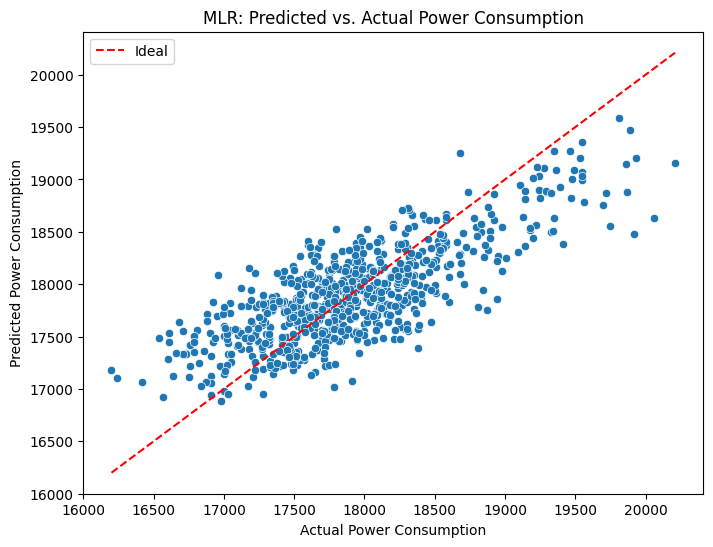


--- Model Evaluation ---
Mean Squared Error: 164685.69953128512
RMSE: 405.81485868716675
R² Score: 0.6041904302039717

Intercept: -10908.306704076484
Coefficients:
  TAP-TAP: 32.18658547338321
  O2사용량_합계: -0.22271012126950884
  온도: 15.752444862684854
  C-inj(佐山): 4.059239062216478


In [6]:
y_pred = model.predict(X_test)

# Actual vs Predicted Power Consumption Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Power Consumption')
plt.ylabel('Predicted Power Consumption')
plt.title('MLR: Predicted vs. Actual Power Consumption')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.legend()

plt.show()

MSE = mean_squared_error(y_test, y_pred)

# Evaluation metrics
print("\n--- Model Evaluation ---")
print("Mean Squared Error:", MSE)
rmse = np.sqrt(MSE)
print("RMSE:", rmse)
print("R² Score:", r2_score(y_test, y_pred))
print("\nIntercept:", model.intercept_)
print("Coefficients:")
for feature, coef in zip(X.columns, model.coef_):
    print(f"  {feature}: {coef}")

C:\Users\User\AppData\Local\Temp\ipykernel_11108\1212759284.py:76: UserWarning: Glyph 20304 (\N{CJK UNIFIED IDEOGRAPH-4F50}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_11108\1212759284.py:76: UserWarning: Glyph 23665 (\N{CJK UNIFIED IDEOGRAPH-5C71}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20304 (\N{CJK UNIFIED IDEOGRAPH-4F50}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23665 (\N{CJK UNIFIED IDEOGRAPH-5C71}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


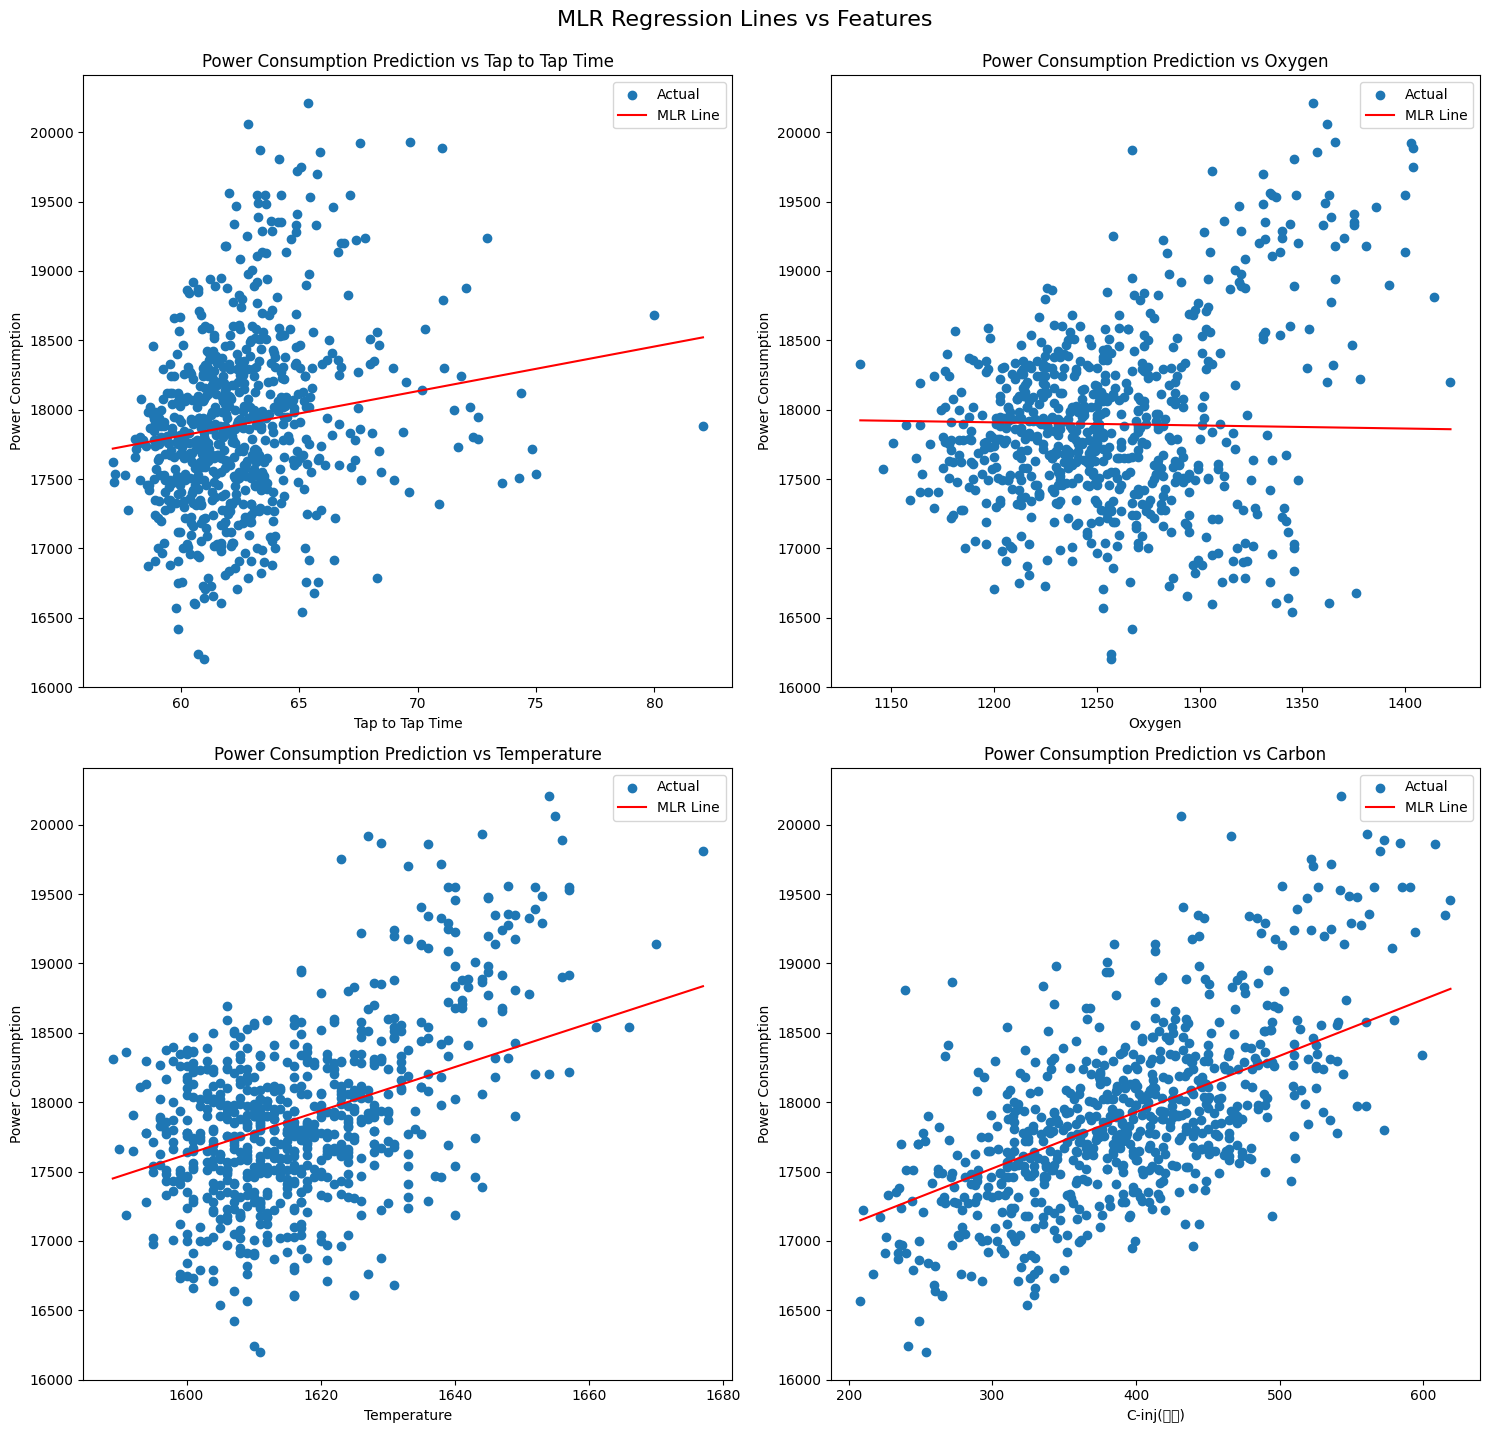

In [7]:
# Get feature means
mean_oxygen = X_test['O2사용량_합계'].mean()
mean_temp = X_test['온도'].mean()
mean_carbon = X_test['C-inj(佐山)'].mean()
mean_tap = X_test['TAP-TAP'].mean()

# Subplot Grid
fig, axes = plt.subplots(2, 2, figsize=(15, 14))
axes = axes.flatten()

# Plot 1: Power consumption vs Tap to tap time
tap_vals = np.linspace(X_test['TAP-TAP'].min(), X_test['TAP-TAP'].max(), 100)
manual_y_tap = (
    model.intercept_ +
    model.coef_[0] * tap_vals +
    model.coef_[1] * mean_oxygen +
    model.coef_[2] * mean_temp +
    model.coef_[3] * mean_carbon
)
axes[0].scatter(X_test['TAP-TAP'], y_test, alpha=1, label='Actual')
axes[0].plot(tap_vals, manual_y_tap, color='red', label='MLR Line')
axes[0].set_xlabel('Tap to Tap Time')
axes[0].set_ylabel('Power Consumption')
axes[0].set_title('Power Consumption Prediction vs Tap to Tap Time')
axes[0].legend()

# Plot 2: Power consumption vs Oxygen
oxygen_vals = np.linspace(X_test['O2사용량_합계'].min(), X_test['O2사용량_합계'].max(), 100)
manual_y_oxygen = (
    model.intercept_ +
    model.coef_[0] * mean_tap +
    model.coef_[1] * oxygen_vals +
    model.coef_[2] * mean_temp +
    model.coef_[3] * mean_carbon
)
axes[1].scatter(X_test['O2사용량_합계'], y_test, alpha=1, label='Actual')
axes[1].plot(oxygen_vals, manual_y_oxygen, color='red', label='MLR Line')
axes[1].set_xlabel('Oxygen')
axes[1].set_ylabel('Power Consumption')
axes[1].set_title('Power Consumption Prediction vs Oxygen')
axes[1].legend()

# Plot 3: Power consumption vs Temperature
temp_vals = np.linspace(X_test['온도'].min(), X_test['온도'].max(), 100)
manual_y_temp = (
    model.intercept_ +
    model.coef_[0] * mean_tap +
    model.coef_[1] * mean_oxygen +
    model.coef_[2] * temp_vals +
    model.coef_[3] * mean_carbon
)
axes[2].scatter(X_test['온도'], y_test, alpha=1, label='Actual')
axes[2].plot(temp_vals, manual_y_temp, color='red', label='MLR Line')
axes[2].set_xlabel('Temperature')
axes[2].set_ylabel('Power Consumption')
axes[2].set_title('Power Consumption Prediction vs Temperature')
axes[2].legend()

# Plot 4: Power consumption vs Carbon
carbon_vals = np.linspace(X_test['C-inj(佐山)'].min(), X_test['C-inj(佐山)'].max(), 100)
manual_y_carbon = (
    model.intercept_ +
    model.coef_[0] * mean_tap +
    model.coef_[1] * mean_oxygen +
    model.coef_[2] * mean_temp +
    model.coef_[3] * carbon_vals
)
axes[3].scatter(X_test['C-inj(佐山)'], y_test, alpha=1, label='Actual')
axes[3].plot(carbon_vals, manual_y_carbon, color='red', label='MLR Line')
axes[3].set_xlabel('C-inj(佐山)')
axes[3].set_ylabel('Power Consumption')
axes[3].set_title('Power Consumption Prediction vs Carbon')
axes[3].legend()

# Final formatting
plt.tight_layout()
plt.suptitle('MLR Regression Lines vs Features', fontsize=16, y=1.02)
plt.show()

# XGBoost

In [8]:
# XGBoost Model set up
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.005,
    max_depth= 4,
    random_state=42
)

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

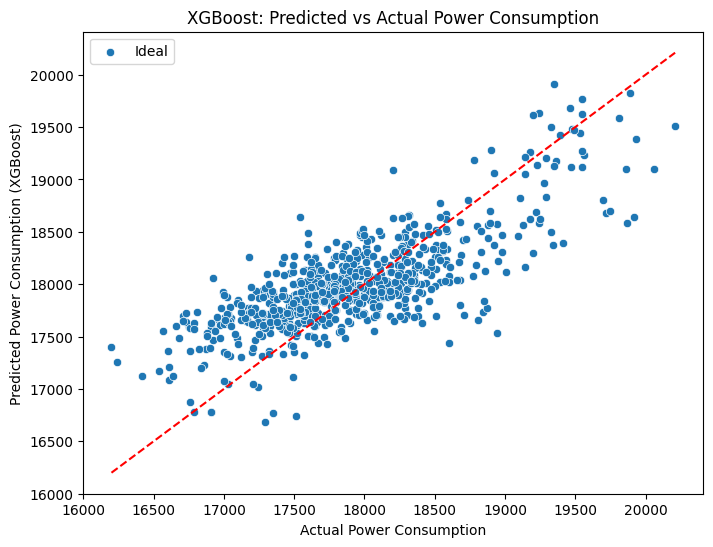


--- XGBoost Model Evaluation ---
Mean Squared Error: 176718.40040387164
XGBoost RMSE: 420.37887720944263
R² Score: 0.5752707476242587


In [9]:
# XGBoost Actual vs Predicted Power Consumption Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=xgb_pred)
plt.xlabel('Actual Power Consumption')
plt.ylabel('Predicted Power Consumption (XGBoost)')
plt.title('XGBoost: Predicted vs Actual Power Consumption')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.legend(['Ideal'])
plt.show()

# Evaluation
print("\n--- XGBoost Model Evaluation ---")
print("Mean Squared Error:", mean_squared_error(y_test, xgb_pred))
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_pred))
print("XGBoost RMSE:", rmse_xgb)
print("R² Score:", r2_score(y_test, xgb_pred))

C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 3 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
C:\Users\User\AppData\Local\Temp\i

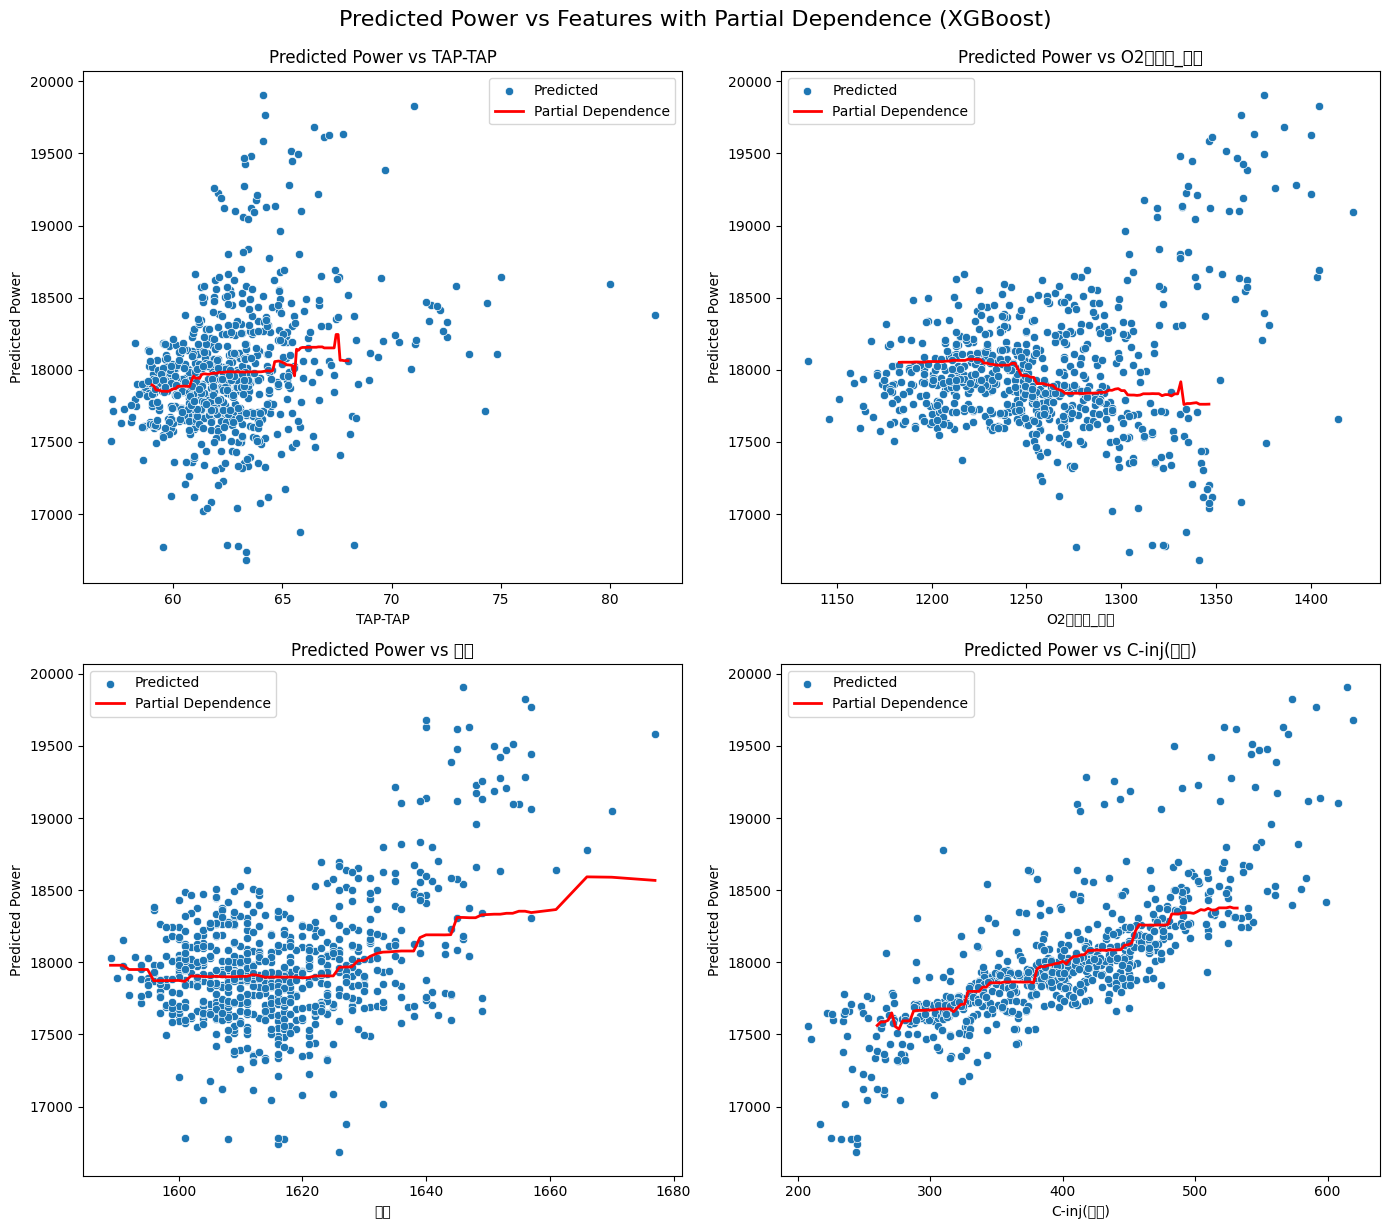

In [10]:
# Features to plot
features = ['TAP-TAP', 'O2사용량_합계', '온도', 'C-inj(佐山)']
n_features = len(features)

# Subplot Grid
rows, cols = 2, 2
fig, axes = plt.subplots(rows, cols, figsize=(14, 12))
axes = axes.flatten()  # To index easily

# Plot the features
for i, feature in enumerate(features):
    ax = axes[i]
    feature_index = X_test.columns.get_loc(feature)

    # Partial dependence
    pd_result = partial_dependence(xgb_model, X_test, [feature_index], kind='average')
    x_vals = pd_result['grid_values'][0]
    y_vals = pd_result['average'][0]

    # Scatter: actual model predictions
    sns.scatterplot(
        x=X_test[feature],
        y=xgb_model.predict(X_test),
        alpha=1,
        ax=ax,
        label='Predicted'
    )

    # Partial dependence line
    ax.plot(x_vals, y_vals, color='red', linewidth=2, label='Partial Dependence')

    # Format
    ax.set_xlabel(feature)
    ax.set_ylabel('Predicted Power')
    ax.set_title(f'Predicted Power vs {feature}')
    ax.legend()

# Remove any unused subplot
if len(axes) > n_features:
    for j in range(n_features, len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Predicted Power vs Features with Partial Dependence (XGBoost)', fontsize=16, y=1.02)
plt.show()

# Time Series Data

C:\Users\User\AppData\Local\Temp\ipykernel_11108\3725979769.py:34: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_11108\3725979769.py:34: UserWarning: Glyph 48264 (\N{HANGUL SYLLABLE BEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48264 (\N{HANGUL SYLLABLE BEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


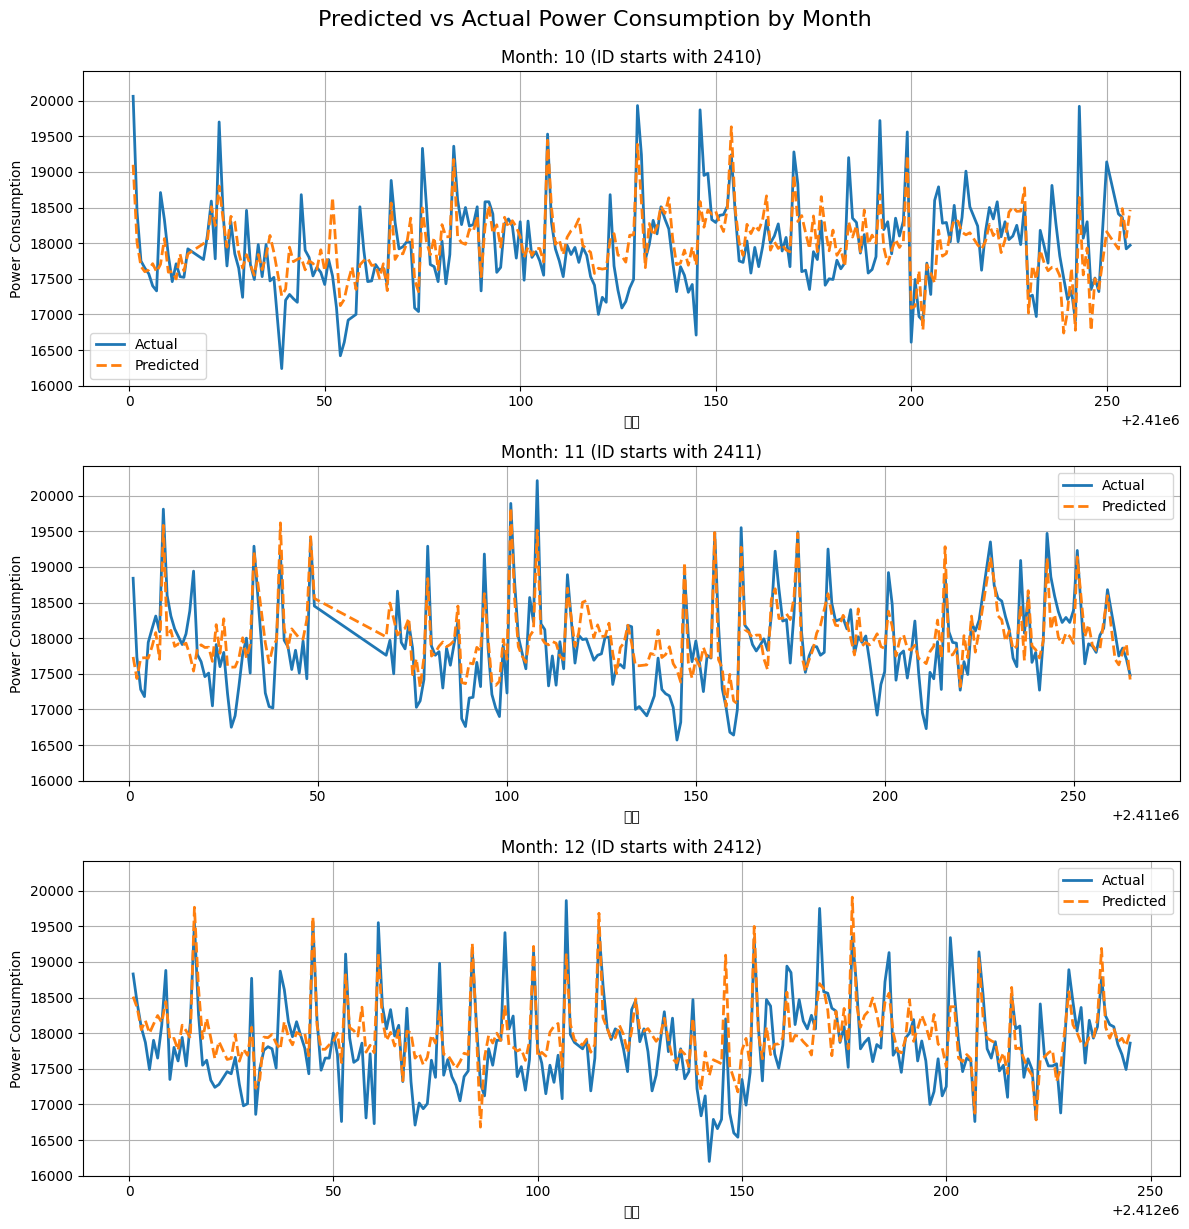

In [11]:
# Combine ID number, Actual power, and Predicted power into one DataFrame
id_aligned_df = df[['강번']].loc[X_test.index].copy()
id_aligned_df['Actual Power'] = y_test.values
id_aligned_df['Predicted Power'] = xgb_pred  # or xgb_pred for XGBoost

# Sort by ID number for line plotting
id_aligned_df = id_aligned_df.sort_values('강번').reset_index(drop=True)

# Extract month from ID (e.g., 2401xxx → 1)
id_aligned_df['Month'] = id_aligned_df['강번'].astype(str).str[2:4].astype(int)

# Prepare list of months to display (exclude missing ones like May if needed)
months = sorted(id_aligned_df['Month'].unique())

# Set up subplots
n_months = len(months)
fig, axes = plt.subplots(n_months, 1, figsize=(12, 4 * n_months), sharey=True)

if n_months == 1:
    axes = [axes]  # Ensure axes is iterable

for i, month in enumerate(months):
    ax = axes[i]
    month_df = id_aligned_df[id_aligned_df['Month'] == month].sort_values('강번')

    ax.plot(month_df['강번'], month_df['Actual Power'], label='Actual', linewidth=2)
    ax.plot(month_df['강번'], month_df['Predicted Power'], label='Predicted', linestyle='--', linewidth=2)
    ax.set_title(f'Month: {month} (ID starts with 24{month:02d})')
    ax.set_xlabel('강번')
    ax.set_ylabel('Power Consumption')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.suptitle('Predicted vs Actual Power Consumption by Month', fontsize=16, y=1.02)
plt.show()


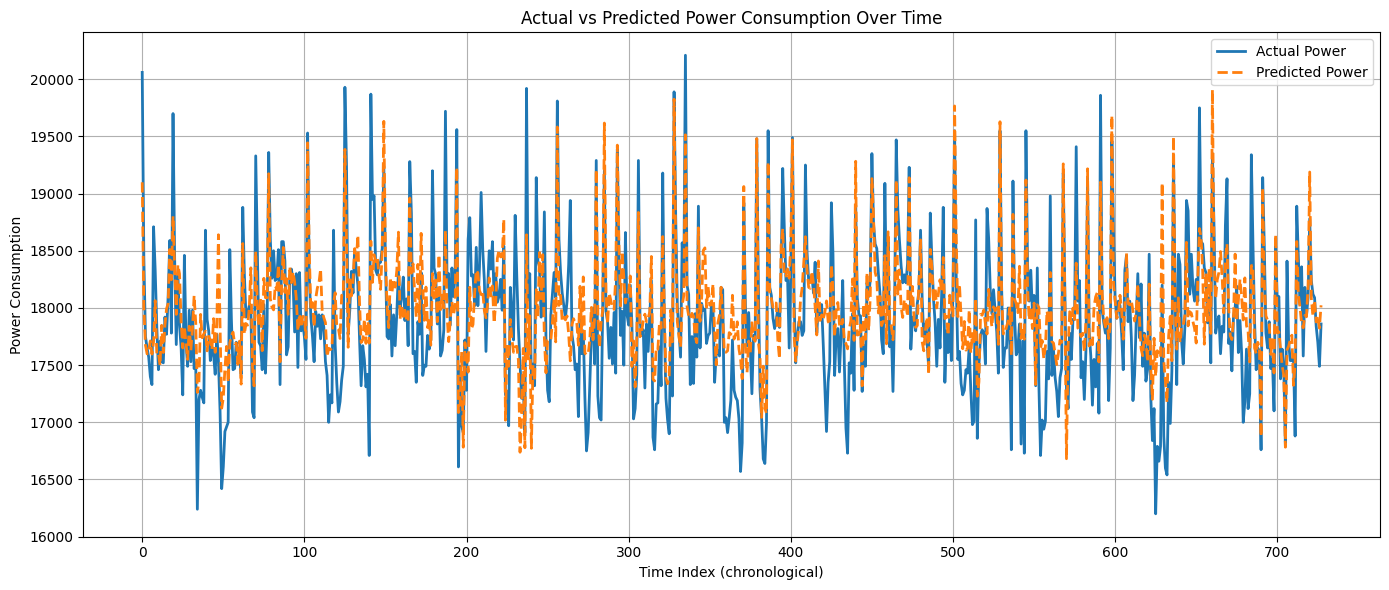

In [12]:
# Create a continuous time index
id_aligned_df['Time Index'] = range(len(id_aligned_df))

# Plot with continuous index
plt.figure(figsize=(14, 6))
plt.plot(id_aligned_df['Time Index'], id_aligned_df['Actual Power'], label='Actual Power', linewidth=2)
plt.plot(id_aligned_df['Time Index'], id_aligned_df['Predicted Power'], label='Predicted Power', linestyle='--', linewidth=2)
plt.xlabel('Time Index (chronological)')
plt.ylabel('Power Consumption')
plt.title('Actual vs Predicted Power Consumption Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()